In [116]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from collections import defaultdict

In [117]:
train_df = pd.read_parquet("data/processed_data/train.parquet")
valid_df = pd.read_parquet("data/processed_data/dev.parquet")
test_df = pd.read_parquet("data/processed_data/test.parquet")
display(train_df)
display(valid_df)
display(test_df)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
8,Trigger_N,F2I568_AERUA/1-145,PF05697.13,MSVKFEETAT...N.EGVLHFTVSKEDAQKA....LKQAYNRVKG....,MSVKFEETATNEGVLHFTVSKEDAQKALKQAYNRVKGKVNIPGFRK...
43,PCRF,D5ANC6_RHOCB/10-198,PF03462.18,ITARFEFLEAKL....NTAL......P.PAEIATL...SREY..SD...,ITARFEFLEAKLNTALPPAEIATLSREYSDLRPVVTEIAAYRQSLD...
68,IPPT,MIAA_ONYPE/37-265,PF01715.17,QMYQKYDIGTAKITL......EEA.....QGI.........K.......,QMYQKYDIGTAKITLEEAQGIKHHLLDFLAPGTNYSIYHFQKDARK...
71,HTH_1,Q9F2K8_STRCO/4-63,PF00126.27,VRHLECFVAVAEES.HFGRAAT.RLGM...AQPPLSQRIQRLEK.E...,VRHLECFVAVAEESHFGRAATRLGMAQPPLSQRIQRLEKELGVRLF...
99,Methyltransf_25,Q2S1D8_SALRD/44-141,PF13649.6,ILDIGCGR.G...R..HA...RA..LV.RR.......G...........,ILDIGCGRGRHARALVRRGWQVTGLDLSEDAVAAARSRVADDDLDV...
...,...,...,...,...,...
13278,His_kinase,D2PX86_KRIFD/171-249,PF06580.13,AE.L..RALRAQISPHFIYNALAAI......A....SF...V.......,AELRALRAQISPHFIYNALAAIASFVRTDPERARELLLEFADFSRY...
13287,Glycos_trans_3N,D7BI04_MEISD/4-63,PF02885.17,...LKKALHA.....E.PLTQDEAHRLMSRI..MS.GD...........,LKKALHAEPLTQDEAHRLMSRIMSGDLTPAQTAGVLIALRTRGETL...
13304,MutS_III,MSH3_MOUSE/498-793,PF05192.18,TTLRNLEM.VQ................NQTDM.................,TTLRNLEMVQNQTDMKTKGSLLWVLDHTKTSFGRRKLKNWVTQPLL...


,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
29,BacA,UPPP_OCHA4/9-259,PF02673.18,AAFLGLIEGLTEFIPVSSTGHL..LLIGHF.L....GFES.........,AAFLGLIEGLTEFIPVSSTGHLLLIGHFLGFESTGKTFEVLIQLGA...
37,DNA_binding_1,R7XUX1_9ACTN/76-156,PF01035.20,AFQQRV.WEQ.LRL..IPYGETASYGEIA................G...,AFQQRVWEQLRLIPYGETASYGEIAGRLGMTNAASRAVGLANGRNP...
43,PCRF,RF1_BACAN/8-202,PF03462.18,VENRYEKLNELL....SDPAII.S..D.SNKLREY...SKEQ..SD...,VENRYEKLNELLSDPAIISDSNKLREYSKEQSDIQETVEVYREYKD...
61,Lipase_GDSL_2,G0RZP4_CHATD/19-209,PF13472.6,CFGDS.LTA.......GYCSM............................,CFGDSLTAGYCSMGAMFHPYHERLEQMLAMAFPDIAFETVEDGVPG...
72,gag_pre-integrs,Q8TFK0_DEBHN/195-267,PF13976.6,NNKYI..KI..........S....N.M...N.H...........E....,NNKYIKISNMNHEIANPFKRKRDLMYYHLMGNHMSLESMKYLIKSG...
...,...,...,...,...,...
12724,Ala_racemase_C,R6NDI3_9CLOT/243-369,PF00842.21,ALSWHARISHIKTL.EAGR.E..ISYGGTF.TTVK.P.TVVATVPV...,ALSWHARISHIKTLEAGREISYGGTFTTVKPTVVATVPVGYADGYP...
12727,THF_DHG_CYH,B2ATS2_PODAN/22-135,PF00763.23,VILADTIAK...K........MLA.EVQ...STL...............,VILADTIAKKMLAEVQSTLSAIQLPRRPTLSAFLANDDPHAYQYAE...
12728,Ig_3,A8X5T7_CAEBR/262-333,PF13927.6,KPIVF......VTPTENLTH...LSVEEGE.LVN....L.TC..NA...,KPIVFVTPTENLTHLSVEEGELVNLTCNAAANPPAHSYEWKHISSG...


,family_id,sequence_name,family_accession,aligned_sequence,sequence
index,,,,,
1,DnaJ_C,M4V8X0_9PROT/126-339,PF01556.18,LRFITEIELEEVISG.K.E.....AQI......EF..............,LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...
9,TrmE_N,B0X5R4_CULQU/21-138,PF10396.9,TIFGLSS..G..S..G.K..C.G..VAVIRVSG................,TIFGLSSGSGKCGVAVIRVSGDASSDVVHRKTSSNKLPAARQAVLR...
16,Lipase_GDSL_2,H6MZH3_GORPV/43-278,PF13472.6,ALGDS.RAS.......GNMPGLQ......................P...,ALGDSRASGNMPGLQPSDGCWRSSTSYPSVLARIAHVRSFVDRSCA...
26,UPF0051,Q7UKR5_RHOBA/213-439,PF01458.17,GQFERT.....L.I.....IVDEG.....ASI..HYV............,GQFERTLIIVDEGASIHYVEGCTAPMYTTESLHSAVVEVIVKKDAR...
56,THF_DHG_CYH,S3CNX4_OPHP1/11-126,PF00763.23,.ILADSIGK...N........MLV.EVQ...ESR...............,ILADSIGKNMLVEVQESRDAFRKEHGIERKLCLAAFLANDDPHAVK...
...,...,...,...,...,...
12706,Chromate_transp,F2F022_SOLSS/4-171,PF02417.15,WELFIAFLIPNLLAYGGGPASI.PLIEHEV........VD.........,WELFIAFLIPNLLAYGGGPASIPLIEHEVVDRYEWMTQSEFSEFLA...
12708,E3_binding,A8LBI7_FRASN/171-205,PF02817.17,.VISPLVR.RLARDNAV....DLR..EL..T....G....T.GPDG...,VISPLVRRLARDNAVDLRELTGTGPDGLIRRRDVE-----------...
12730,THF_DHG_CYH,C6WZR6_FLAB3/4-120,PF00763.23,ILDGLKVSK...E........IKN.EIR...TDV...............,ILDGLKVSKEIKNEIRTDVEKIVEGKRRPPHLVAILVGQNGASISY...


In [88]:
MAX_SEQ_LEN = train_df["sequence"].str.len().max()
N_CLASSES = len(train_df["family_accession"].unique())
print(MAX_SEQ_LEN, N_CLASSES)

256 64


In [89]:
le = LabelEncoder()
y_train = train_df["family_accession"].to_numpy()
y_train = le.fit_transform(y_train)
y_valid = le.transform(valid_df["family_accession"].to_numpy())
y_test = le.transform(test_df["family_accession"].to_numpy())

display(y_train, y_valid, y_test)

array([51, 45, 26, ..., 50, 42, 58], shape=(66226,))

array([34, 14, 45, ..., 60, 51, 12], shape=(8249,))

array([24, 54, 56, ..., 12,  7, 59], shape=(8242,))

In [90]:
def make_features(df):
    # iloc remove start/end padding of ""
    X = df["sequence"].str.split("", expand=True).iloc[:, 1:-1].to_numpy()
    return X


make_features(train_df)

array([['M', 'S', 'V', ..., '-', '-', '-'],
       ['I', 'T', 'A', ..., '-', '-', '-'],
       ['Q', 'M', 'Y', ..., '-', '-', '-'],
       ...,
       ['T', 'T', 'L', ..., 'R', 'E', 'Q'],
       ['A', 'E', 'F', ..., '-', '-', '-'],
       ['V', 'V', 'D', ..., '-', '-', '-']],
      shape=(66226, 256), dtype=object)

In [91]:
alphabet = ["-"] + list("ACDEFGHIKLMNPQRSTVWY")
alphabet

['-',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [92]:
oe = OrdinalEncoder(categories=[alphabet] * MAX_SEQ_LEN)
X_train = oe.fit_transform(make_features(train_df))
X_valid = oe.transform(make_features(valid_df))
X_test = oe.transform(make_features(test_df))
display(X_train, X_valid, X_test)

array([[11., 16., 18., ...,  0.,  0.,  0.],
       [ 8., 17.,  1., ...,  0.,  0.,  0.],
       [14., 11., 20., ...,  0.,  0.,  0.],
       ...,
       [17., 17., 10., ..., 15.,  4., 14.],
       [ 1.,  4.,  5., ...,  0.,  0.,  0.],
       [18., 18.,  3., ...,  0.,  0.,  0.]], shape=(66226, 256))

array([[ 1.,  1.,  5., ...,  0.,  0.,  0.],
       [ 1.,  5., 14., ...,  0.,  0.,  0.],
       [18.,  4., 12., ...,  0.,  0.,  0.],
       ...,
       [ 9., 13.,  8., ...,  0.,  0.,  0.],
       [11.,  9.,  8., ...,  0.,  0.,  0.],
       [10., 10.,  3., ...,  0.,  0.,  0.]], shape=(8249, 256))

array([[10., 15.,  5., ...,  0.,  0.,  0.],
       [17.,  8.,  5., ...,  0.,  0.,  0.],
       [ 1., 10.,  6., ...,  0.,  0.,  0.],
       ...,
       [ 8., 10.,  3., ...,  0.,  0.,  0.],
       [ 3., 17., 18., ...,  0.,  0.,  0.],
       [ 9., 12., 15., ...,  0.,  0.,  0.]], shape=(8242, 256))

In [93]:
# models:
# 1. simple knn
# 2. protcnn
# 3.

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)

metrics = [
    (accuracy_score, {}),
    (balanced_accuracy_score, {}),
    (f1_score, {"average": "weighted"}),
]

for metric, kwargs in metrics:
    print(f"{metric.__name__}: {metric(y_valid, y_pred, **kwargs):.3f}")

accuracy_score: 0.932
balanced_accuracy_score: 0.931
f1_score: 0.931


In [95]:
for average in ["micro", "macro", "weighted"]:
    score = f1_score(y_valid, y_pred, average=average)
    print(f"{average} f1-score {score:.3f}")

micro f1-score 0.932
macro f1-score 0.931
weighted f1-score 0.931


In [99]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

/var/folders/_1/x45gcqk13td92ct_53v0nwtr0000gn/T/ipykernel_42175/1989681173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/_1/x45gcqk13td92ct_53v0nwtr0000gn/T/ipykernel_42175/1989681173.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid = torch.tensor(X_valid, dtype=torch.float32)
/var/folders/_1/x45gcqk13td92ct_53v0nwtr0000gn/T/ipykernel_42175/1989681173.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/var

In [ ]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
train_set = TensorDataset(X_train, y_train)
dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

In [ ]:
# consider adding layer norm/batch norm
model = nn.Sequential(nn.Linear(MAX_SEQ_LEN, 128), nn.ReLU(), nn.Linear(128, N_CLASSES))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

n_epochs = 10
loss_histories = defaultdict(list)
acc_histories = defaultdict(list)

for epoch in range(n_epochs):
    train_loss = 0
    for step, batch in enumerate(tqdm(dataloader)):
        xb, yb = batch
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader.dataset)
    loss_histories["train"].append(train_loss)

    model.eval()
    val_logits = model(X_valid)
    val_loss = F.cross_entropy(val_logits, y_valid, reduction="mean").item()
    loss_histories["valid"].append(val_loss)

    y_pred = F.softmax(val_logits, dim=-1).argmax(axis=-1)
    val_acc = balanced_accuracy_score(y_valid, y_pred)
    tqdm.write(
        f"Epoch: {epoch}, train loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc {val_acc:.4f}"
    )
    model.train()

  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 0, train loss: 1.9007, val_loss: 0.9830, val_acc 0.7119


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.7759, val_loss: 0.6549, val_acc 0.8050


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.5745, val_loss: 0.5350, val_acc 0.8471


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.4831, val_loss: 0.4786, val_acc 0.8614


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.4295, val_loss: 0.4435, val_acc 0.8683


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.3949, val_loss: 0.4234, val_acc 0.8722


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.3692, val_loss: 0.4059, val_acc 0.8827


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.3503, val_loss: 0.3905, val_acc 0.8866


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.3346, val_loss: 0.3807, val_acc 0.8896


  0%|          | 0/1035 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.3230, val_loss: 0.3790, val_acc 0.8865


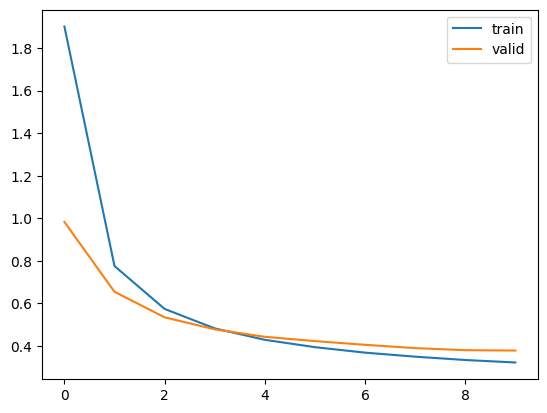

In [ ]:
import matplotlib.pyplot as plt

# simple baseline
# 1. knn
# 2. simple NN (optional)
# 3. simple transformer
# 4. protCNN
# 5. pretrained transformer embeddings followed by other models

plt.figure()
plt.plot(loss_histories["train"], label="train")
plt.plot(loss_histories["valid"], label="valid")
plt.legend()